In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cvxopt as opt
from cvxopt import blas, solvers

pd.options.plotting.backend = "matplotlib"

# Data Analysis

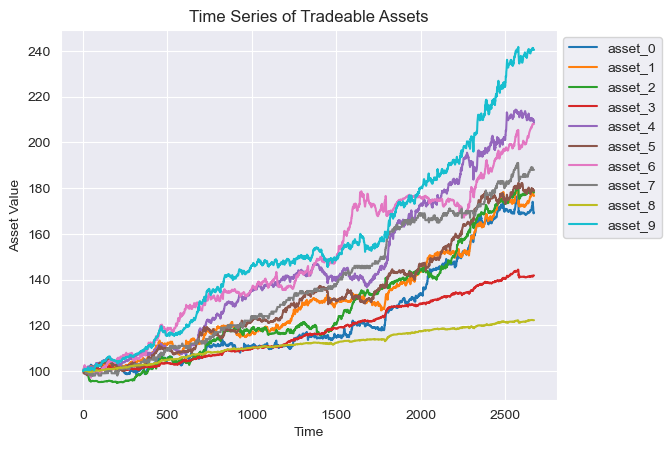

In [244]:
# Load Excel data into a DataFrame
data = pd.read_excel('MR_tradeables.xlsx')

# Rename columns with meaningful names
columns={k:'asset_'+str(k) for k in range(len(data.columns))}
data.rename(columns=columns, inplace=True)

# Plot the data
data.plot()
plt.title('Time Series of Tradeable Assets')
plt.xlabel('Time')
plt.ylabel('Asset Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position

 According to this plot asset_9 overperform our baskets of assets and it seems that the asset_8 is not really the best investment solution but let's examine the different returns.

First, in order to evaluate our strategy and avoid a data leakage, we have to divide our datasets in two part, a training set and validation set.

In [245]:
n_samples=data.shape[0]
n_train=int(n_samples*0.8)+1

In [246]:
return_data_=data.pct_change()*100
return_data_=return_data_.drop(0)
return_data_training=return_data_.iloc[:n_train,:]
return_data_validation=return_data_.iloc[n_train:,:]

In [247]:
return_data_training_details=return_data_training.describe()#.style.background_gradient(axis=0)
return_data_training_details.loc['sharpe']=return_data_training_details.loc['mean']/return_data_training_details.loc['std']
return_data_training_details=return_data_training_details.sort_values(axis=1,by='sharpe',ascending=False)
return_data_training_details

asset_8      asset_3      asset_9      asset_4      asset_6  \
count   2139.000000  2139.000000  2139.000000  2139.000000  2139.000000   
mean       0.007975     0.013234     0.029735     0.027659     0.025807   
std        0.052087     0.106377     0.271484     0.281242     0.275550   
min       -0.327082    -0.701809    -1.300748    -1.216707    -2.637072   
25%       -0.014603    -0.046244    -0.126568    -0.125110    -0.109318   
50%        0.007067     0.009521     0.015309     0.012378     0.000000   
75%        0.031679     0.071653     0.185102     0.175136     0.159176   
max        0.358339     0.689339     1.681340     1.437484     1.727945   
sharpe     0.153117     0.124404     0.109528     0.098347     0.093657   

            asset_2      asset_7      asset_1      asset_5      asset_0  
count   2139.000000  2139.000000  2139.000000  2139.000000  2139.000000  
mean       0.017651     0.025102     0.019826     0.020544     0.018196  
std        0.222625     0.337177     0.269737     0.280801     0.283977  
min       -1.338909    -1.204819    -1.727737    -2.409441    -1.504316  
25%       -0.090696     0.000000    -0.123744    -0.122199    -0.118422  
50%        0.011209     0.000000     0.012775     0.004711     0.000000  
75%        0.128875     0.000000     0.173454     0.158609     0.150262  
max        1.569966     1.290323     1.165059     2.367021     1.984942  
sharpe     0.079286     0.074449     0.073503     0.073164     0.064075

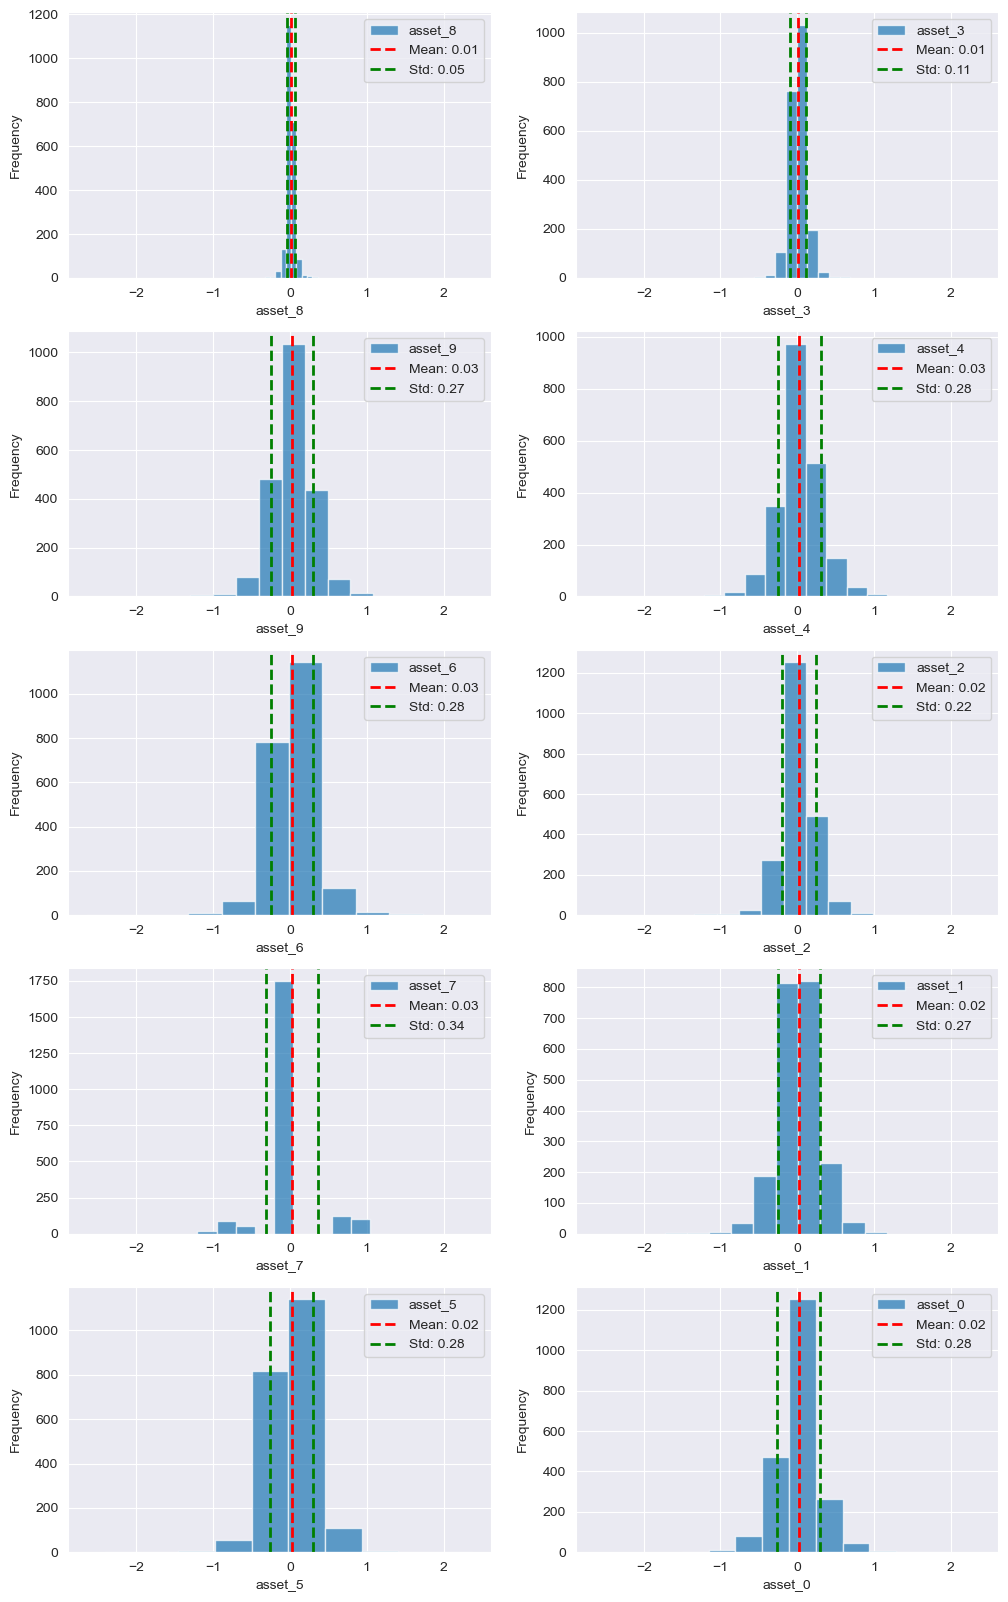

In [248]:
fig, axs = plt.subplots(nrows=len(data.columns)//2, ncols=2, figsize=(12, 20), sharex=True)

for i, col in enumerate(return_data_training_details.columns):
    ax = axs[i//2, (i%2)]
    
    # Plot histogram
    ax.hist(return_data_training[col], label=col, alpha=0.7)
    
    # Add mean and std to the plot
    mean_val = return_data_training[col].mean()
    std_val = return_data_training[col].std()
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=2, label=f'Std: {std_val:.2f}')
    ax.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=2)
    
    # Set labels and legend
    ax.legend()
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    axs[i//2,(i%2)].xaxis.set_tick_params(labelbottom=True)

If we are a risk taker, invest in asset_9 could be a good option, it has the highest return with relative good volatility comparatively to other highest return asset. But in the other case ( we want a more secure investment), the asset 8 is the best option. Comparatively to before a further analysis conclude that asset_8 is a good option if we doesn't a risky investment. Is there a better solution that includes, all those assets ?

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'asset_0'),
  Text(0, 1.5, 'asset_1'),
  Text(0, 2.5, 'asset_2'),
  Text(0, 3.5, 'asset_3'),
  Text(0, 4.5, 'asset_4'),
  Text(0, 5.5, 'asset_5'),
  Text(0, 6.5, 'asset_6'),
  Text(0, 7.5, 'asset_7'),
  Text(0, 8.5, 'asset_8'),
  Text(0, 9.5, 'asset_9')])

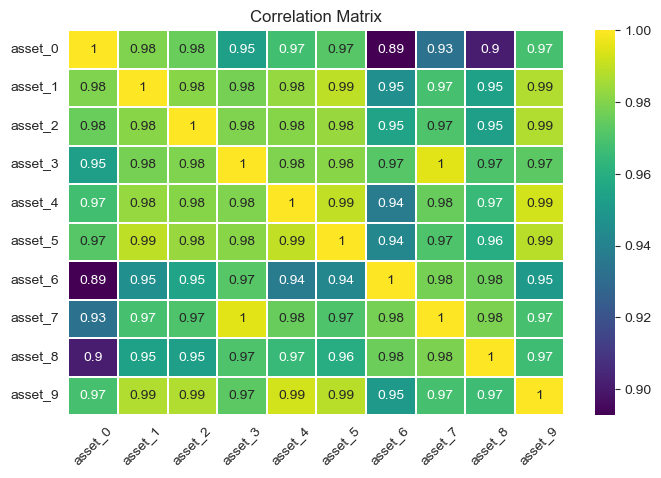

In [249]:
corr_matrix = data.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=.01)

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)


There is a strong correlation between the different assets, with a minimun value of 0.89.
Let's study a portfolio build by with all those assets.

Text(0.5, 1.0, 'return and risk of randomly generated portfolios')

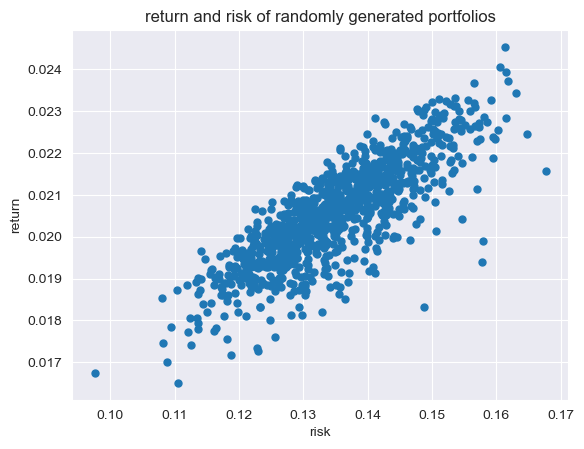

In [250]:
def rand_weights(n,short=False):
    ''' Produces n random weights that sum to 1 '''
    
    k = np.random.uniform(-1, 1, n) if short else np.random.uniform(0, 1, n)
    
    return k / sum(abs(k))    

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=0))
    w = np.asmatrix(rand_weights(returns.shape[1]))
    C=np.asmatrix(np.cov(returns,rowvar=False))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_data_training) 
    for _ in range(n_portfolios)
])

fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('risk')
plt.ylabel('return')
plt.title('return and risk of randomly generated portfolios')
# py.iplot_mpl(fig, filename='mean_std', strip_style=True)

# Long Only Portfolio 

     pcost       dcost       gap    pres   dres
 0: -2.0079e-02 -1.0279e+00  1e+00  1e-16  4e+00
 1: -2.0142e-02 -3.7845e-02  2e-02  7e-17  6e-02
 2: -2.2525e-02 -2.7332e-02  5e-03  5e-17  1e-02
 3: -2.5543e-02 -2.7342e-02  2e-03  2e-16  6e-18
 4: -2.6084e-02 -2.6152e-02  7e-05  2e-16  8e-18
 5: -2.6123e-02 -2.6125e-02  2e-06  1e-16  5e-18
 6: -2.6124e-02 -2.6124e-02  2e-08  3e-17  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9970e-02 -1.0276e+00  1e+00  0e+00  4e+00
 1: -2.0031e-02 -3.7615e-02  2e-02  8e-17  6e-02
 2: -2.2358e-02 -2.7041e-02  5e-03  2e-16  1e-02
 3: -2.5204e-02 -2.6895e-02  2e-03  2e-16  2e-17
 4: -2.5728e-02 -2.5782e-02  5e-05  4e-17  8e-18
 5: -2.5765e-02 -2.5766e-02  6e-07  1e-16  6e-18
 6: -2.5766e-02 -2.5766e-02  6e-09  2e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9847e-02 -1.0274e+00  1e+00  1e-16  4e+00
 1: -1.9907e-02 -3.7358e-02  2e-02  7e-17  6e-02
 2: -2.2173e-02 -2.6717e

Text(0.5, 1.0, 'Efficient Frontier and Optimal Portfolio (Long Only)')

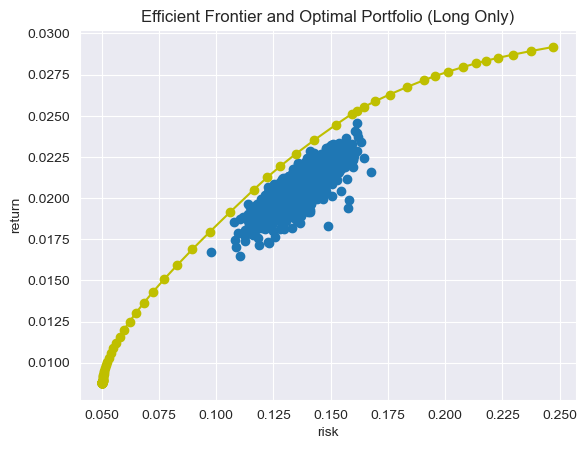

In [251]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.asmatrix(returns)

    N = 100
    lambda_values = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    Cov_matrix = opt.matrix(np.cov(returns, rowvar=False))
    return_matrix = opt.matrix(np.mean(returns, axis=0).astype('float'),(n,1),'d')

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(lambda_ * Cov_matrix, -return_matrix, G, h, A, b)['x'] for lambda_ in lambda_values]

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(return_matrix, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, Cov_matrix * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE. HERE WE FIND THE BEST LAMBDA WHICH GIVE THE BEST SHARPE RETURN/RISK
    risk_equation = np.polyfit(returns, risks, 2)
    best_sharpe = np.sqrt(risk_equation[2] / risk_equation[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(best_sharpe * Cov_matrix), -return_matrix, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights_long_only, returns_long_only, risks_long_only = optimal_portfolio(return_data_training)

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('return')
plt.xlabel('risk')
plt.plot(risks_long_only, returns_long_only, 'y-o')
plt.title('Efficient Frontier and Optimal Portfolio (Long Only)')

# py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

Text(0.5, 1.0, 'Long Only Portfolio Weights Heatmap')

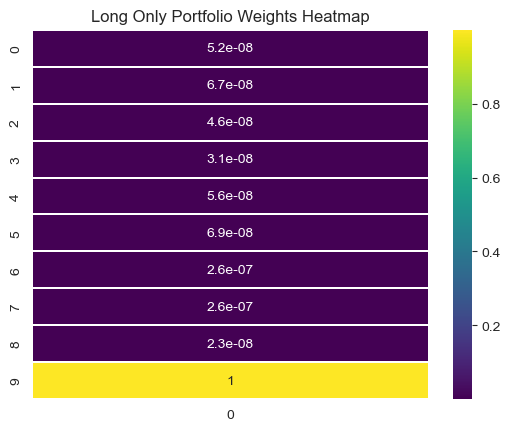

In [252]:
sns.heatmap(weights_long_only, annot=True, cmap='viridis', linewidths=.01)
plt.title('Long Only Portfolio Weights Heatmap')

As we conclude before, for a long only portfolio ( only positive weights in the portfolio ), we must completely invest in a asset_9. Will we get the same conclusion, if we are allowed to be short.

# Long Short Portfolio 

In [253]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.asmatrix(returns)

    N = 100
    lambda_values = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    Cov_matrix = opt.matrix(np.cov(returns, rowvar=False))
    return_matrix = opt.matrix(np.mean(returns, axis=0).astype('float'),(n,1),'d')

    # Create constraint matrices
    # G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    # h = opt.matrix(0.0, (n, 1))
    G = opt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = opt.matrix(np.vstack((opt.matrix(1.0, (n, 1)), opt.matrix(1.0, (n, 1)))))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(lambda_ * Cov_matrix, -return_matrix, G, h, A, b)['x'] for lambda_ in lambda_values]

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(return_matrix, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, Cov_matrix * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE. HERE WE FIND THE BEST LAMBDA WHICH GIVE THE BEST SHARPE RETURN/RISK
    risk_equation = np.polyfit(returns, risks, 2)
    best_sharpe = np.sqrt(risk_equation[2] / risk_equation[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(best_sharpe * Cov_matrix), -return_matrix, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights_long_short, returns_long_short, risks_long_short = optimal_portfolio(return_data_training)

# py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

     pcost       dcost       gap    pres   dres
 0: -1.9913e-02 -2.1901e+01  2e+01  4e-17  3e-16
 1: -2.0204e-02 -3.5664e-01  3e-01  2e-16  1e-15
 2: -3.2350e-02 -8.8802e-02  6e-02  2e-16  2e-16
 3: -4.5545e-02 -5.3077e-02  8e-03  8e-16  9e-18
 4: -4.8009e-02 -4.8636e-02  6e-04  1e-16  1e-17
 5: -4.8189e-02 -4.8232e-02  4e-05  2e-16  6e-18
 6: -4.8210e-02 -4.8212e-02  2e-06  4e-16  6e-18
 7: -4.8211e-02 -4.8211e-02  2e-08  4e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9807e-02 -2.1900e+01  2e+01  2e-16  3e-16
 1: -2.0092e-02 -3.5471e-01  3e-01  2e-16  5e-16
 2: -3.1639e-02 -8.7206e-02  6e-02  2e-16  7e-17
 3: -4.3723e-02 -5.0805e-02  7e-03  2e-16  5e-18
 4: -4.5914e-02 -4.6402e-02  5e-04  4e-16  8e-18
 5: -4.6028e-02 -4.6058e-02  3e-05  2e-16  4e-18
 6: -4.6034e-02 -4.6035e-02  1e-06  4e-16  2e-18
 7: -4.6034e-02 -4.6034e-02  1e-08  3e-16  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9689e-02 -2.1898e

Text(0.5, 1.0, 'Long Short Portfolio Weights Heatmap')

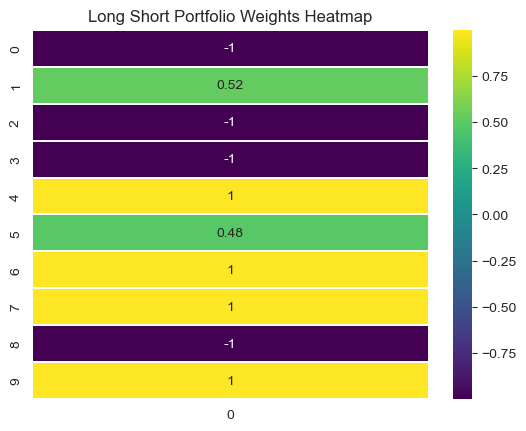

In [254]:
sns.heatmap(weights_long_short, annot=True, cmap='viridis', linewidths=.01)
plt.title('Long Short Portfolio Weights Heatmap')


We reach to the same conclusion that we must definately invest on the asset 9 to reach the best performance, if we are able to take some risk, of course. Then we can also long the assets 7, 6,5,4,1 and short the assets 8,3,2,0

Let's compare the performance of our portfolio, first on the training set then on test set

In [255]:
def plot_expected_return(returns):

    returns_training_long_only = returns.apply(lambda x: x * weights_long_only.flatten(), axis=1).sum(
        axis=1)
    returns_training_long_short = returns.apply(lambda x: x * weights_long_short.flatten(), axis=1).sum(
        axis=1)
    returns_training_equaly_weighted = returns.apply(lambda x: x * (1 / returns.shape[0]),
                                                                  axis=1).sum(axis=1)
    returns_training_random_long_only = returns.apply(
        lambda x: x * rand_weights(returns.shape[1]), axis=1).sum(axis=1)
    returns_training_random_long_short = returns.apply(
        lambda x: x * rand_weights(returns.shape[1], short=True), axis=1).sum(axis=1)

    
    df_strategies = pd.DataFrame({'long_only': returns_training_long_only, 'long_short': returns_training_long_short,
                                  'equaly_weighted': returns_training_equaly_weighted,
                                  'random_long_only': returns_training_random_long_only,
                                  'random_long_short': returns_training_random_long_short})

    expected_return = df_strategies.expanding().mean()  # Adjust window size as needed
    expected_return.plot()
    
    sharpe_ratio=df_strategies.mean()/df_strategies.std()
    for strat in sharpe_ratio.index:
        print(f'sharpe ratio of {strat} is : {sharpe_ratio[strat]}\n')


sharpe ratio of long_only is : 0.10952786673710059

sharpe ratio of long_short is : 0.09950255191088697

sharpe ratio of equaly_weighted is : 0.15982702021362902

sharpe ratio of random_long_only is : 0.15155344294456763

sharpe ratio of random_long_short is : -0.04585288837895661


Text(0.5, 1.0, 'Expected Return on Training Set')

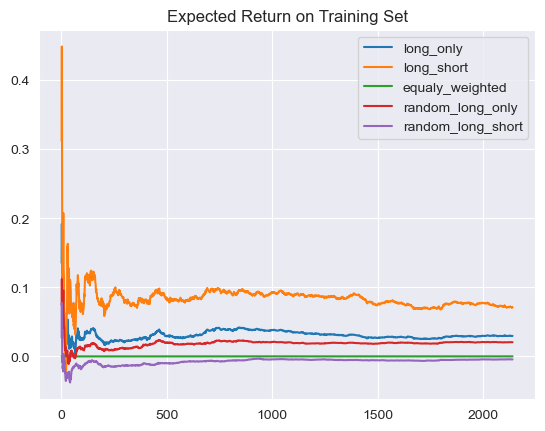

In [256]:
plot_expected_return(return_data_training)
plt.title('Expected Return on Training Set')

On the training dataset, as we could expect, the optimised strategies (long_only and long_short) overperform. The long_short strategy is definately better than the long_only strategy (invest only in asset_9). However, we can notice the fact that the random_long_only is quite good, we could explain that by the fact that all the assets follow a upside trend.

What about the validation dataset ?

sharpe ratio of long_only is : 0.13700253723522096

sharpe ratio of long_short is : 0.09017010437366205

sharpe ratio of equaly_weighted is : 0.1627509674181978

sharpe ratio of random_long_only is : 0.14439290221869644

sharpe ratio of random_long_short is : 0.006057304833390412


Text(0.5, 1.0, 'Expected Return on Validation Set')

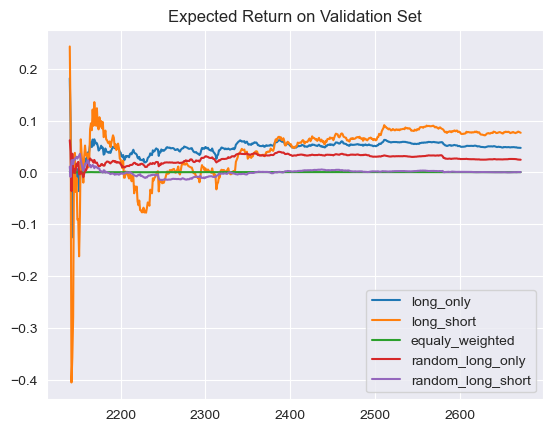

In [257]:
plot_expected_return(return_data_validation)
plt.title('Expected Return on Validation Set')

According to the results on the test set, if we fear about any loose, it is not a good idea to do a long short strategy but in the other case, if we are a risk taker, long short is the best option. This result is quite different from what we could expect base on the training curve. There is kind of "overfitting" or "stability" issue. We have to correct it using a regularisation

# Long Short Portfolio with ridge regularisation

In [258]:
def optimal_portfolio_ridge(returns,alpha=0.01):
    n = returns.shape[1]
    # returns = np.asmatrix(returns)
    returns = np.asmatrix(returns)
    N = 100
    lambda_values = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    Cov_matrix = opt.matrix(np.cov(returns, rowvar=False))
    return_matrix = opt.matrix(np.mean(returns, axis=0).astype('float'),(n,1),'d')

    # Create constraint matrices
    # G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    # h = opt.matrix(0.0, (n, 1))
    G = opt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = opt.matrix(np.vstack((opt.matrix(1.0, (n, 1)), opt.matrix(1.0, (n, 1)))))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(opt.matrix(lambda_ * Cov_matrix+alpha*np.eye(n)), -return_matrix, G, h, A, b)['x'] for lambda_ in lambda_values]

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(return_matrix, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, Cov_matrix * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE. HERE WE FIND THE BEST LAMBDA WHICH GIVE THE BEST SHARPE RETURN/RISK
    risk_equation = np.polyfit(returns, risks, 2)
    best_sharpe = np.sqrt(risk_equation[2] / risk_equation[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(best_sharpe * Cov_matrix+alpha*np.eye(n)), -return_matrix, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights_long_short_ridge, returns_long_short_ridge, risks_long_short_ridge = optimal_portfolio_ridge(return_data_training)

# py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

     pcost       dcost       gap    pres   dres
 0: -1.9411e-02 -2.1900e+01  2e+01  2e-16  4e-16
 1: -1.9697e-02 -3.5453e-01  3e-01  2e-16  9e-16
 2: -2.7364e-02 -6.6530e-02  4e-02  2e-16  1e-16
 3: -3.0530e-02 -3.2653e-02  2e-03  2e-16  8e-18
 4: -3.0669e-02 -3.0757e-02  9e-05  2e-16  5e-18
 5: -3.0672e-02 -3.0674e-02  2e-06  2e-16  5e-18
 6: -3.0672e-02 -3.0672e-02  2e-08  2e-16  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9306e-02 -2.1899e+01  2e+01  1e-16  3e-16
 1: -1.9585e-02 -3.5262e-01  3e-01  4e-16  7e-16
 2: -2.6907e-02 -6.5372e-02  4e-02  2e-16  7e-17
 3: -2.9787e-02 -3.1774e-02  2e-03  2e-16  6e-18
 4: -2.9900e-02 -2.9974e-02  7e-05  2e-16  3e-18
 5: -2.9901e-02 -2.9902e-02  1e-06  2e-16  3e-18
 6: -2.9901e-02 -2.9901e-02  1e-08  4e-16  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9188e-02 -2.1897e+01  2e+01  3e-16  4e-16
 1: -1.9459e-02 -3.5047e-01  3e-01  2e-16  5e-16
 2: -2.6414e-02 -6.4096e

     pcost       dcost       gap    pres   dres
 0: -1.7406e-02 -2.1897e+01  2e+01  5e-17  3e-16
 1: -1.7670e-02 -3.4636e-01  3e-01  2e-16  9e-16
 2: -2.0213e-02 -3.4833e-02  1e-02  2e-16  4e-17
 3: -2.0297e-02 -2.0456e-02  2e-04  2e-16  7e-18
 4: -2.0297e-02 -2.0299e-02  2e-06  2e-16  5e-18
 5: -2.0297e-02 -2.0297e-02  2e-08  2e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7301e-02 -2.1895e+01  2e+01  6e-17  5e-16
 1: -1.7558e-02 -3.4454e-01  3e-01  2e-16  9e-16
 2: -2.0010e-02 -3.4364e-02  1e-02  2e-16  4e-17
 3: -2.0088e-02 -2.0244e-02  2e-04  2e-16  5e-18
 4: -2.0088e-02 -2.0090e-02  2e-06  2e-16  4e-18
 5: -2.0088e-02 -2.0088e-02  2e-08  2e-16  2e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7184e-02 -2.1894e+01  2e+01  5e-17  3e-16
 1: -1.7433e-02 -3.4250e-01  3e-01  2e-16  9e-16
 2: -1.9787e-02 -3.3846e-02  1e-02  2e-16  3e-17
 3: -1.9859e-02 -2.0009e-02  2e-04  2e-16  4e-18
 4: -1.9859e-02 -1.9860e

Text(0.5, 1.0, 'Ridge Regularized Portfolio Weights')

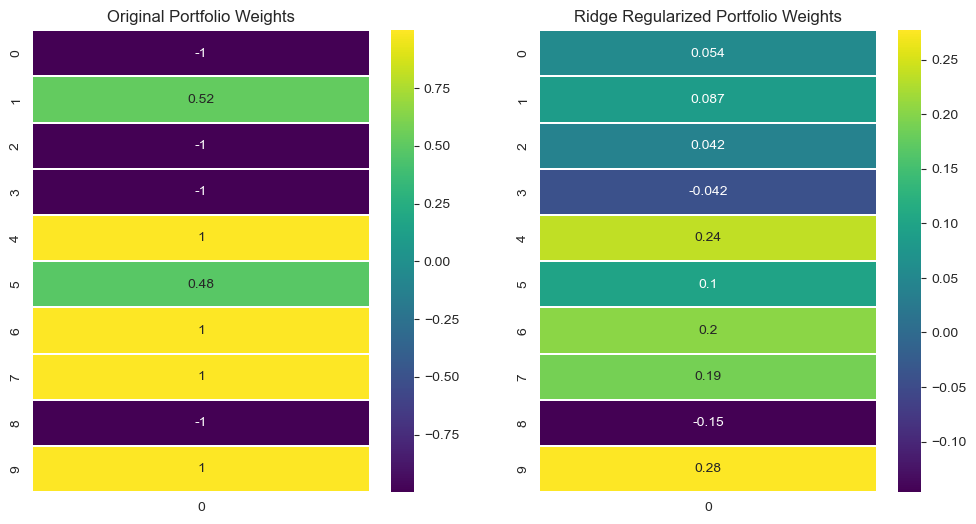

In [259]:
weights_long_short_ridge, returns_long_short_ridge, risks_long_short_ridge = optimal_portfolio_ridge(return_data_training,alpha=0.05)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)

sns.heatmap(weights_long_short, annot=True, cmap='viridis', linewidths=.01, ax=axs[0])
axs[0].set_title('Original Portfolio Weights')

sns.heatmap(weights_long_short_ridge, annot=True, cmap='viridis', linewidths=.01, ax=axs[1])
axs[1].set_title('Ridge Regularized Portfolio Weights')

In [260]:
alpha_values=np.linspace(1e-3,1,20)
sharpe_alpha=[]
for alpha in alpha_values:
    weights_alpha,_,_=optimal_portfolio_ridge(return_data_validation,alpha=alpha)
    return_alpha=return_data_validation.apply(lambda x: x * weights_alpha.flatten(), axis=1).sum(
        axis=1)
    sharpe_alpha.append(np.mean(return_alpha)/np.std(return_alpha+1e-7))

     pcost       dcost       gap    pres   dres
 0: -2.6654e-02 -2.2005e+01  2e+01  2e-16  4e-16
 1: -2.7627e-02 -4.5063e-01  4e-01  2e-16  6e-16
 2: -6.0270e-02 -1.2141e-01  6e-02  2e-16  6e-17
 3: -8.3504e-02 -9.1615e-02  8e-03  2e-16  1e-17
 4: -8.6884e-02 -8.7394e-02  5e-04  4e-16  8e-18
 5: -8.7052e-02 -8.7063e-02  1e-05  2e-16  5e-18
 6: -8.7055e-02 -8.7055e-02  1e-07  3e-16  6e-18
 7: -8.7055e-02 -8.7055e-02  1e-09  3e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6467e-02 -2.2003e+01  2e+01  5e-17  4e-16
 1: -2.7419e-02 -4.4756e-01  4e-01  2e-16  9e-16
 2: -5.8878e-02 -1.1838e-01  6e-02  3e-16  9e-17
 3: -8.1291e-02 -8.9101e-02  8e-03  2e-16  1e-17
 4: -8.4490e-02 -8.4999e-02  5e-04  2e-16  1e-17
 5: -8.4667e-02 -8.4680e-02  1e-05  4e-16  1e-17
 6: -8.4674e-02 -8.4674e-02  1e-07  4e-16  1e-17
 7: -8.4674e-02 -8.4674e-02  1e-09  3e-16  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6258e-02 -2.2000e

Text(0, 0.5, 'Sharpe Ratios')

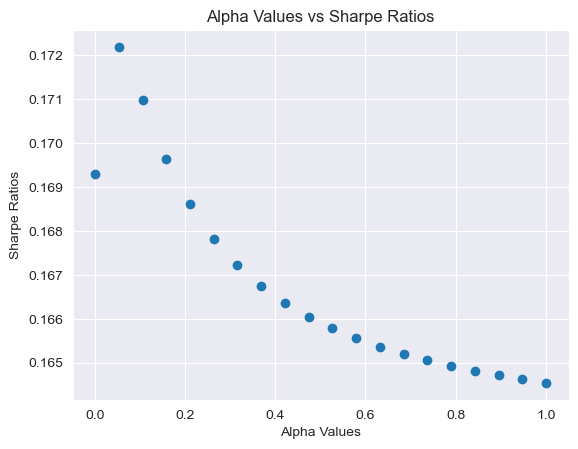

In [261]:
plt.scatter(alpha_values,sharpe_alpha)
plt.title('Alpha Values vs Sharpe Ratios')
plt.xlabel('Alpha Values')
plt.ylabel('Sharpe Ratios')

In [262]:
alpha_values=np.linspace(0,0.02,50)
sharpe_alpha=[]
for alpha in alpha_values:
    weights_alpha,_,_=optimal_portfolio_ridge(return_data_validation,alpha=alpha)
    return_alpha=return_data_validation.apply(lambda x: x * weights_alpha.flatten(), axis=1).sum(
        axis=1)
    sharpe_alpha.append(np.mean(return_alpha)/np.std(return_alpha+1e-7))

     pcost       dcost       gap    pres   dres
 0: -2.6704e-02 -2.2005e+01  2e+01  5e-17  4e-16
 1: -2.7679e-02 -4.5096e-01  4e-01  3e-16  5e-16
 2: -6.1759e-02 -1.2433e-01  6e-02  1e-16  6e-17
 3: -8.6326e-02 -9.5439e-02  9e-03  4e-16  1e-17
 4: -9.0382e-02 -9.1008e-02  6e-04  4e-16  9e-18
 5: -9.0580e-02 -9.0619e-02  4e-05  2e-16  1e-17
 6: -9.0585e-02 -9.0588e-02  2e-06  2e-16  1e-17
 7: -9.0586e-02 -9.0586e-02  3e-08  3e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6517e-02 -2.2003e+01  2e+01  4e-16  4e-16
 1: -2.7472e-02 -4.4788e-01  4e-01  2e-16  4e-16
 2: -6.0311e-02 -1.2120e-01  6e-02  2e-16  5e-17
 3: -8.4145e-02 -9.2854e-02  9e-03  2e-16  1e-17
 4: -8.7900e-02 -8.8524e-02  6e-04  2e-16  1e-17
 5: -8.8097e-02 -8.8123e-02  3e-05  2e-16  7e-18
 6: -8.8100e-02 -8.8101e-02  5e-07  3e-16  1e-17
 7: -8.8100e-02 -8.8100e-02  5e-09  3e-16  8e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6308e-02 -2.2000e

Text(0, 0.5, 'Sharpe Ratios')

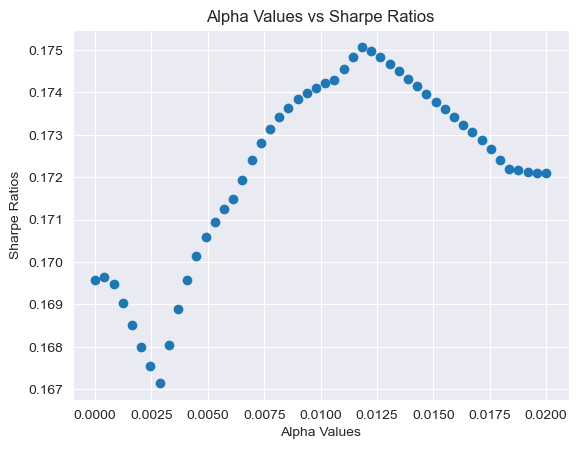

In [263]:
plt.scatter(alpha_values,sharpe_alpha)
plt.title('Alpha Values vs Sharpe Ratios')
plt.xlabel('Alpha Values')
plt.ylabel('Sharpe Ratios')

We get the maximun sharpe ratio for alpha~0.0120

In [264]:
weights_long_short_ridge, returns_long_short_ridge, risks_long_short_ridge = optimal_portfolio_ridge(return_data_training,alpha=0.0120)

     pcost       dcost       gap    pres   dres
 0: -1.9311e-02 -2.1900e+01  2e+01  5e-17  4e-16
 1: -1.9596e-02 -3.5411e-01  3e-01  2e-16  7e-16
 2: -2.6682e-02 -6.3353e-02  4e-02  2e-16  6e-17
 3: -2.9104e-02 -3.0780e-02  2e-03  2e-16  7e-18
 4: -2.9164e-02 -2.9205e-02  4e-05  3e-16  1e-17
 5: -2.9164e-02 -2.9165e-02  4e-07  2e-16  9e-18
 6: -2.9164e-02 -2.9164e-02  4e-09  2e-16  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9206e-02 -2.1899e+01  2e+01  4e-17  3e-16
 1: -1.9483e-02 -3.5220e-01  3e-01  2e-16  6e-16
 2: -2.6256e-02 -6.2262e-02  4e-02  4e-16  5e-17
 3: -2.8462e-02 -3.0027e-02  2e-03  3e-16  6e-18
 4: -2.8511e-02 -2.8545e-02  3e-05  2e-16  8e-18
 5: -2.8511e-02 -2.8511e-02  3e-07  3e-16  7e-18
 6: -2.8511e-02 -2.8511e-02  3e-09  1e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9088e-02 -2.1897e+01  2e+01  1e-16  4e-16
 1: -1.9357e-02 -3.5006e-01  3e-01  4e-16  6e-16
 2: -2.5796e-02 -6.1060e

Text(0.5, 1.0, 'Ridge Regularized Portfolio Weights')

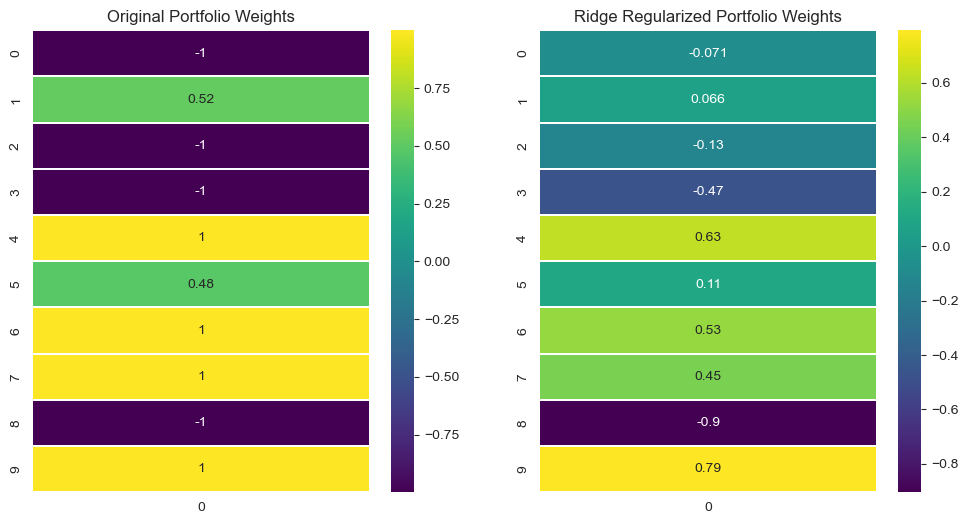

In [265]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)

sns.heatmap(weights_long_short, annot=True, cmap='viridis', linewidths=.01, ax=axs[0])
axs[0].set_title('Original Portfolio Weights')

sns.heatmap(weights_long_short_ridge, annot=True, cmap='viridis', linewidths=.01, ax=axs[1])
axs[1].set_title('Ridge Regularized Portfolio Weights')

In [266]:
def plot_expected_return_ridge(returns):
    returns_training_long_short_ridge = returns.apply(lambda x: x * weights_long_short_ridge.flatten(), axis=1).sum(
        axis=1)
    returns_training_long_only = returns.apply(lambda x: x * weights_long_only.flatten(), axis=1).sum(
        axis=1)
    returns_training_long_short = returns.apply(lambda x: x * weights_long_short.flatten(), axis=1).sum(
        axis=1)
    returns_training_equaly_weighted = returns.apply(lambda x: x * (1 / returns.shape[0]),
                                                                  axis=1).sum(axis=1)
    returns_training_random_long_only = returns.apply(
        lambda x: x * rand_weights(returns.shape[1]), axis=1).sum(axis=1)
    returns_training_random_long_short = returns.apply(
        lambda x: x * rand_weights(returns.shape[1], short=True), axis=1).sum(axis=1)

    df_strategies = pd.DataFrame({'long_only': returns_training_long_only, 'long_short': returns_training_long_short,
                                  'long_short_ridge':returns_training_long_short_ridge,
                                  'equaly_weighted': returns_training_equaly_weighted,
                                  'random_long_only': returns_training_random_long_only,
                                  'random_long_short': returns_training_random_long_short
                                  })

    expected_return = df_strategies.expanding().mean()  # Adjust window size as needed
    expected_return.plot()
    
    sharpe_ratio=df_strategies.mean()/df_strategies.std()
    for strat in sharpe_ratio.index:
        print(f'sharpe ratio of {strat} is : {sharpe_ratio[strat]}\n')
    

sharpe ratio of long_only is : 0.10952786673710059

sharpe ratio of long_short is : 0.09950255191088697

sharpe ratio of long_short_ridge is : 0.11624782063716109

sharpe ratio of equaly_weighted is : 0.15982702021362902

sharpe ratio of random_long_only is : 0.13846286514924872

sharpe ratio of random_long_short is : -0.009968188417501123


Text(0.5, 1.0, 'Expected Return on training set')

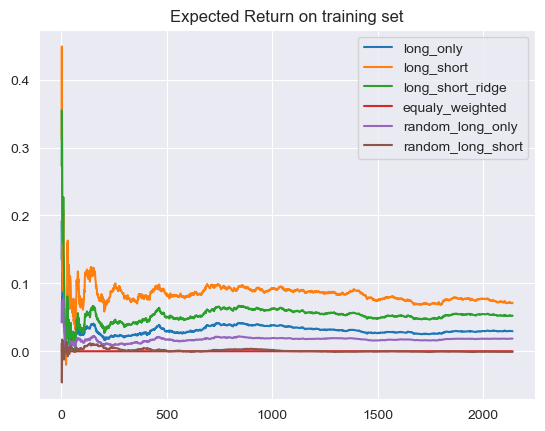

In [267]:
plot_expected_return_ridge(return_data_training)
plt.title('Expected Return on training set')

sharpe ratio of long_only is : 0.13700253723522096

sharpe ratio of long_short is : 0.09017010437366205

sharpe ratio of long_short_ridge is : 0.126889081860272

sharpe ratio of equaly_weighted is : 0.1627509674181978

sharpe ratio of random_long_only is : 0.1454797426557053

sharpe ratio of random_long_short is : 0.0026980854285076853


Text(0.5, 1.0, 'Expected Return on validation set')

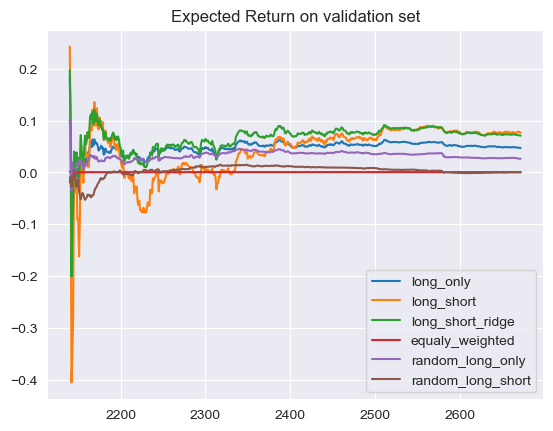

In [268]:
plot_expected_return_ridge(return_data_validation)
plt.title('Expected Return on validation set')

The long_short_ridge (green) is more stable and overperform all the other strategies in average and the client is not supposed to  face any loose.